<a href="https://colab.research.google.com/github/CS20M038/CS6910-assignment_3/blob/main/DL_Assignment_3_Arjun_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
#import all the libraries that would be used in this notebook
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import LSTM,Dense
import csv
import os
from keras.utils.vis_utils import plot_model

In [145]:
# to mount to the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

In [146]:
#make sure to upload the Dakshina Dataset in your drive and name the folder as Dakshina_Dataset
dakshina_dataset_hindi = '/content/drive/MyDrive/Dakshina_Dataset/hi/lexicons'

In [147]:
dev_dataset_path = os.path.join(dakshina_dataset_hindi,"hi.translit.sampled.dev.tsv")
train_dataset_path = os.path.join(dakshina_dataset_hindi,"hi.translit.sampled.train.tsv")
test_dataset_path = os.path.join(dakshina_dataset_hindi,"hi.translit.sampled.test.tsv")

In [175]:
def load_dataset(path,test_dataset = False):
    dataset = open(path)
    read_dataset = csv.reader(dataset,delimiter = '\t')
    x = []
    y = []
    for row in read_dataset:
        x.append(row[1])
        if test_dataset:
            y.append(row[0])
        else:
            y.append("\t"+row[0]+'\n')

    return np.array(x),np.array(y)


In [149]:
x_raw_train,y_raw_train = load_dataset(train_dataset_path,False)

In [176]:
x_raw_test,y_raw_test = load_dataset(test_dataset_path,True)

In [150]:
english_alphabets = 'abcdefghijklmnopqrstuvwxyz'
english_alpha2index = {"PAD": 0}
for index,alpha in enumerate(english_alphabets):
    english_alpha2index[alpha] = index + 1

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabets.append('\t')
hindi_alphabets.append('\n')
hindi_alpha2index = {"PAD" : 0}
for index,alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index + 1

english_index2alpha = {0: "PAD"}
hindi_index2alpha = {0: "PAD"}

for index,alpha in enumerate(english_alphabets):
    english_index2alpha[index + 1] = alpha

for index,alpha in enumerate(hindi_alphabets):
    hindi_index2alpha[index + 1] = alpha



In [151]:
def get_integer_encode(word,alpha2index,max_length = 25):
    integer_encode = np.zeros((max_length,),dtype='int')
    for index,alpha in enumerate(word):
        integer_encode[index] = alpha2index[alpha]
    return integer_encode

def encode_docs(docs,alpha2index,max_length = 25):
    encoded_docs = np.zeros((docs.shape[0],max_length),dtype='int')
    for index,word in enumerate(docs):
        encoded_docs[index] = get_integer_encode(word,alpha2index)
    return encoded_docs



In [152]:
integer_encoded_x_train = encode_docs(x_raw_train,english_alpha2index)
integer_encoded_y_train = encode_docs(y_raw_train,hindi_alpha2index)

In [153]:
decoder_input_data = np.zeros((integer_encoded_y_train.shape[0],25,len(hindi_alpha2index)),dtype="float32")
decoder_output_data = np.zeros((integer_encoded_y_train.shape[0],25,len(hindi_alpha2index)),dtype="float32")

for i,integer_encoded_data in enumerate(integer_encoded_y_train):
    for t,integer in enumerate(integer_encoded_data):
        decoder_input_data[i, t, integer]= 1.0
        if t > 0:
            decoder_output_data[i, t - 1, integer] = 1.0

In [182]:
batch_size = 64  
epochs = 25
latent_dim = 256

In [183]:
embedding_inputs = keras.Input(shape=(25))
embedding_layer = Embedding(len(english_alpha2index), 125 , input_length=25)
encoder_inputs = embedding_layer(embedding_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, len(hindi_alpha2index)))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(len(hindi_alpha2index), activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([embedding_inputs, decoder_inputs], decoder_outputs)

In [184]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [integer_encoded_x_train, decoder_input_data],
    decoder_output_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
)

Epoch 1/25
622/622 [==============================] - 191s 302ms/step - loss: 1.1451 - accuracy: 0.7386 - val_loss: 0.9244 - val_accuracy: 0.7665
Epoch 2/25
622/622 [==============================] - 201s 323ms/step - loss: 0.7544 - accuracy: 0.8006 - val_loss: 0.8717 - val_accuracy: 0.7954
Epoch 3/25
622/622 [==============================] - 185s 297ms/step - loss: 0.6064 - accuracy: 0.8345 - val_loss: 0.7435 - val_accuracy: 0.8184
Epoch 4/25
622/622 [==============================] - 184s 295ms/step - loss: 0.4774 - accuracy: 0.8660 - val_loss: 0.6884 - val_accuracy: 0.8375
Epoch 5/25
622/622 [==============================] - 184s 295ms/step - loss: 0.3836 - accuracy: 0.8901 - val_loss: 0.6404 - val_accuracy: 0.8472
Epoch 6/25
622/622 [==============================] - 184s 295ms/step - loss: 0.3134 - accuracy: 0.9090 - val_loss: 0.5655 - val_accuracy: 0.8677
Epoch 7/25
622/622 [==============================] - 184s 296ms/step - loss: 0.2615 - accuracy: 0.9227 - val_loss: 0.5317 -

In [185]:
model.save("/content/drive/MyDrive/s2s")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/s2s/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/s2s/assets


In [118]:
model = keras.models.load_model("/content/drive/MyDrive/s2s")

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 25)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 25, 125)           3375      
_________________________________________________________________
lstm_10 (LSTM)               [(None, 256), (None, 256) 391168    
Total params: 394,543
Trainable params: 394,543
Non-trainable params: 0
_________________________________________________________________
Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None, 131)]  0                                            
___________________________________________________________________

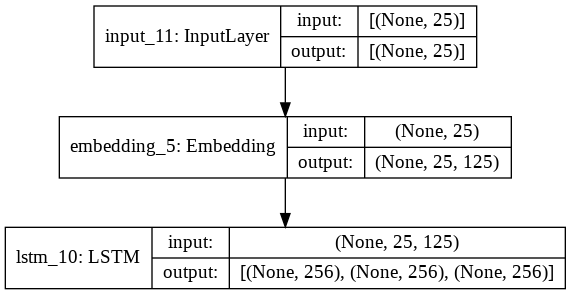

In [186]:
#model.summary()

embedding_inputs = model.input[0]  # input_1
embedding_l1 = model.layers[1]
encoder_inputs = embedding_l1(embedding_inputs)
encoder_lstm = model.layers[3]
encoder_outputs, state_h_enc, state_c_enc = encoder_lstm(encoder_inputs)
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(embedding_inputs, encoder_states)
encoder_model.summary()

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_5")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[4]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[5]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)
decoder_model.summary()
plot_model(encoder_model, to_file='decoder_model.png', show_shapes=True)

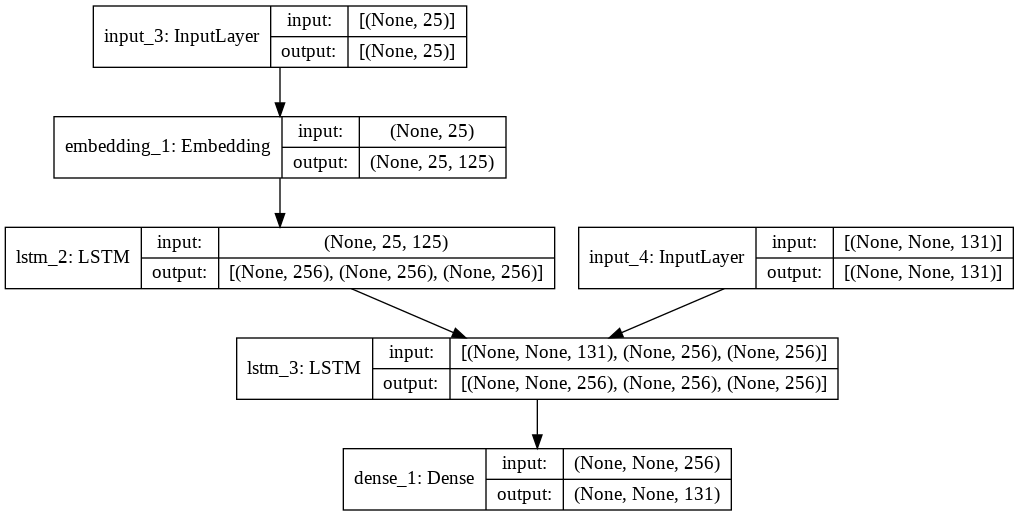

In [41]:
plot_model(model, to_file='model.png', show_shapes=True)

In [199]:
def decode_sequence(word):
    input_seq = get_integer_encode(word,english_alpha2index)
    input_seq = input_seq.reshape(1,25)
    
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1, len(hindi_alpha2index)))
    # Populate the first character of target sequence with the start character.
    target_seq[0,0, hindi_alpha2index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_word = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        sampled_char = hindi_index2alpha[sampled_token_index]
        

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_word) > 25:
            stop_condition = True
            break

        decoded_word += sampled_char

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1,len(hindi_alpha2index)))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_word

In [203]:
def test():
    correct = 0
    for english_word,hindi_word in zip(x_raw_test,y_raw_test):
    
        predicted_hindi_word = decode_sequence(english_word)
        print(english_word+"  "+hindi_word+"  "+predicted_hindi_word)
        if predicted_hindi_word == hindi_word:
            correct += 1

    acc = (correct/x_raw_test.shape[0])*100
    return acc
    

In [204]:
print(test())

ank  अंक  एंक
anka  अंक  अंका
ankit  अंकित  आंकित
anakon  अंकों  अनकों
ankhon  अंकों  अंखों
ankon  अंकों  एंकों
angkor  अंकोर  आंगोर
ankor  अंकोर  एंकर
angaarak  अंगारक  अंगारक
angarak  अंगारक  अंगारक
angraji  अंग्रज़ी  अंगर्जी
angreji  अंग्रज़ी  अंग्रेजी
angrzi  अंग्रज़ी  अंगर्जी
antah  अंतः  अंताह
antaha  अंतः  अंताहा
antarmukh  अंतर्मुख  अंतरूम्क
antmurkh  अंतर्मुख  अंतुम्राख
antrmukh  अंतर्मुख  अंतरूम्क
andrabee  अंद्राबी  अंदर्बी
andrabi  अंद्राबी  अंदर्बी
andha  अंधा  अंधा
andhapan  अंधापन  अंधपान
andheri  अंधेरी  अंधेरी
ambaani  अंबानी  अमबानी
ambani  अंबानी  अम्बानी
akram  अकरम  अक्रम
acapulco  अकापुल्को  अपैकलय
akapulko  अकापुल्को  अकापुलक
akhand  अखंड  अखंड
akhil  अखिल  अखिल
agavai  अगवाई  अग्वाई
agvaai  अगवाई  अग्वाई
augustine  अगस्टाइन  अगास्टिने
augustustine  अगस्टाइन  अगस्टस्प्यूति
agsta  अगस्ता  अग्स्त
agusta  अगस्ता  अगुसत्
augusta  अगस्ता  अगस्त्ता
agr  अग्र  एग्र
agra  अग्र  अगरा
achambha  अचंभा  अचंभा
achanbha  अचंभा  अचंभा
achievement  अचीवमेंट  अचितेदनें
achivement